# Fine-Tuning RoBERTa using LoRA

In [1]:
!pip install peft

  Obtaining dependency information for peft from https://files.pythonhosted.org/packages/8b/1b/aee2a330d050c493642d59ba6af51f3910cb138ea48ede228c84c204a5af/peft-0.7.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.1 MB/s eta 0:00:00a 0:00:01m


## Importing the libraries

In [2]:
import re
import gc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import DatasetDict, Dataset, load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments, DefaultDataCollator, DataCollatorWithPadding

from peft import LoraConfig, TaskType, get_peft_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
SEED_VAL = 42
NUM_SAMPLES = 2000
TEST_RATIO = 0.2
BATCH_SIZE = 16
MAX_LENGTH = 128
NUM_CLASSES = 2
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 15
DATASET_NAME = ("quora","qqp",)
MODEL_NAME = 'roberta-large'

## Setting Up the GPU

In [5]:
np.object = object
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Load the dataset

In [6]:
raw_dataset = load_dataset(*(DATASET_NAME), split='train')
print(f'length of raw dataset: {len(raw_dataset)}')
print(f'sample of raw dataset: {raw_dataset[0]}')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset quora downloaded and prepared to /root/.cache/huggingface/datasets/quora/qqp/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04. Subsequent calls will reuse this data.
length of raw dataset: 404290
sample of raw dataset: {'questions': {'id': [1, 2], 'text': ['What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?']}, 'is_duplicate': False}


In [7]:
raw_dataset = raw_dataset.shuffle()
raw_dataset = raw_dataset.select(range(NUM_SAMPLES))
print(f'length of raw dataset: {len(raw_dataset)}')
print(f'sample of raw dataset: {raw_dataset[0]}')

length of raw dataset: 2000
sample of raw dataset: {'questions': {'id': [128040, 367718], 'text': ['How long can it take to learn Java pretty well?', 'How long does it take to learn Java?']}, 'is_duplicate': True}


## Preprocessing the dataset

In [8]:
splited_dataset = raw_dataset.train_test_split(test_size=TEST_RATIO, shuffle=True, seed=SEED_VAL)
train_dataset = splited_dataset['train']
valid_dataset = splited_dataset['test']

In [9]:
train_dataset = train_dataset.map(lambda x: {'question1': x['questions']['text'][0], 'question2': x['questions']['text'][1], 'labels': int(x['is_duplicate'])})
valid_dataset = valid_dataset.map(lambda x: {'question1': x['questions']['text'][0], 'question2': x['questions']['text'][1], 'labels': int(x['is_duplicate'])})

print(f'sample of train dataset: {train_dataset[0]}')

  0%|          | 0/1600 [00:00<?, ?ex/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

sample of train dataset: {'questions': {'id': [193928, 97615], 'text': ['Is a sea of massive gravitons what ripples when galaxy clusters collide and is it what waves in a double slit experiment?', 'Is dark matter a sea of massive dark photons that ripple when galaxy clusters collide and wave in a double slit experiment?']}, 'is_duplicate': True, 'question1': 'Is a sea of massive gravitons what ripples when galaxy clusters collide and is it what waves in a double slit experiment?', 'question2': 'Is dark matter a sea of massive dark photons that ripple when galaxy clusters collide and wave in a double slit experiment?', 'labels': 1}


In [10]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

train_tokenized = train_dataset.map(
    lambda x: tokenizer(
        x['question1'], 
        x['question2'], 
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
    ),
    batched=True,
)
    
valid_tokenized = valid_dataset.map(
    lambda x: tokenizer(
        x['question1'], 
        x['question2'], 
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
    ),
    batched=True,
)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
train_tokenized = train_tokenized.remove_columns(['questions', 'is_duplicate', 'question1', 'question2'])
valid_tokenized = valid_tokenized.remove_columns(['questions', 'is_duplicate', 'question1', 'question2'])


In [12]:
train_tokenized = train_tokenized.with_format('pt')
valid_tokenized = valid_tokenized.with_format('pt')

In [13]:
print(f'train dataset: {train_tokenized}')
print(f'length of train dataset: {len(train_tokenized)}')
print(f'sample of train dataset: {train_tokenized[0]}')

train dataset: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1600
})
length of train dataset: 1600
sample of train dataset: {'labels': tensor(1), 'input_ids': tensor([    0,  6209,    10,  3342,     9,  2232, 20969,   405,  1790,    99,
          910, 39453,    77, 22703, 28255, 36191,     8,    16,    24,    99,
         6995,    11,    10,  1457, 34915,  9280,   116,     2,     2,  6209,
         2933,   948,    10,  3342,     9,  2232,  2933, 44239,    14, 31228,
           77, 22703, 28255, 36191,     8,  4605,    11,    10,  1457, 34915,
         9280,   116,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     

In [14]:
print(f'validation dataset: {valid_tokenized}')
print(f'length of validation dataset: {len(valid_tokenized)}')
print(f'sample of validation dataset: {valid_tokenized[0]}')

validation dataset: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 400
})
length of validation dataset: 400
sample of validation dataset: {'labels': tensor(0), 'input_ids': tensor([   0, 2264,   16,    5,  144, 2721,  766,  116,    2,    2, 2264,   16,
           5,  144, 2721,  766,   13,   10, 2182,  116,    2,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,

In [15]:
del raw_dataset, splited_dataset, train_dataset, valid_dataset
gc.collect()

130

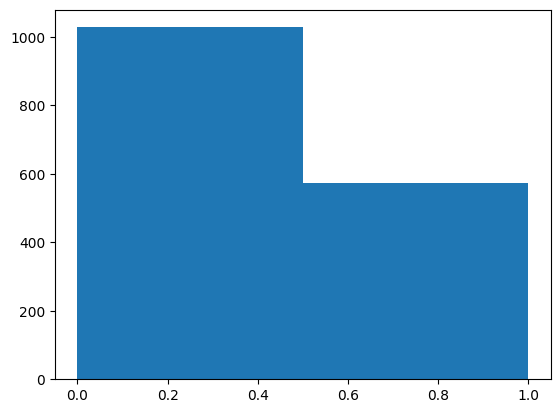

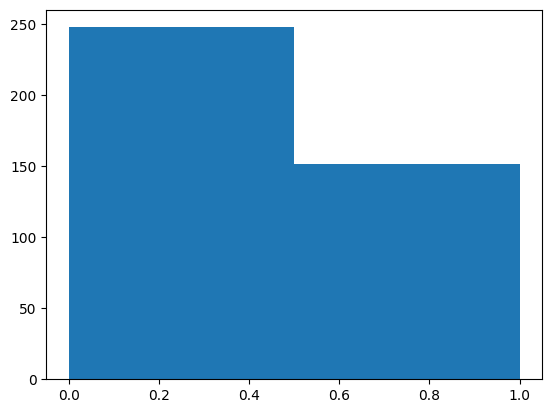

In [16]:
train_labels = train_tokenized['labels'].numpy().tolist()
valid_labels = valid_tokenized['labels'].numpy().tolist()

plt.hist(train_labels, bins=NUM_CLASSES)
plt.show()

plt.hist(valid_labels, bins=NUM_CLASSES)
plt.show()

In [17]:
STEPS_PER_EPOCH = len(train_tokenized) // BATCH_SIZE

## Fine-Tuning RoBERTa Without Freezing Any Layers

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)
model.to(device)
model

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 355361794
Number of learnable parameters: 355361794


In [ ]:
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy='steps',
    eval_steps=STEPS_PER_EPOCH // 3,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    data_collator=data_collator,
    compute_metrics=lambda pred: {
        'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        'precision': precision_score(pred.label_ids, pred.predictions.argmax(-1)),
        'recall': recall_score(pred.label_ids, pred.predictions.argmax(-1)),
        'f1': f1_score(pred.label_ids, pred.predictions.argmax(-1)),        
    },
)

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
33,No log,0.677457,0.580000,0.000000,0.000000,0.000000
66,No log,0.594012,0.695000,0.676923,0.523810,0.590604
99,No log,0.509240,0.750000,0.663462,0.821429,0.734043
132,No log,0.454956,0.780000,0.696078,0.845238,0.763441
165,No log,0.431628,0.792500,0.709360,0.857143,0.776280
198,No log,0.412000,0.820000,0.807692,0.750000,0.777778
231,No log,0.500872,0.820000,0.730769,0.904762,0.808511
264,No log,0.582330,0.825000,0.760638,0.851190,0.803371
297,No log,0.556004,0.845000,0.804598,0.833333,0.818713
330,No log,0.634422,0.820000,0.800000,0.761905,0.780488


TrainOutput(global_step=750, training_loss=0.1664401849110921, metrics={'train_runtime': 1286.7224, 'train_samples_per_second': 18.652, 'train_steps_per_second': 0.583, 'total_flos': 5591588179968000.0, 'train_loss': 0.1664401849110921, 'epoch': 15.0})

In [ ]:
baseline_results = trainer.evaluate()
print(baseline_results)

{'eval_loss': 1.3162132501602173, 'eval_accuracy': 0.83, 'eval_precision': 0.7777777777777778, 'eval_recall': 0.8333333333333334, 'eval_f1': 0.8045977011494253, 'eval_runtime': 6.4153, 'eval_samples_per_second': 62.351, 'eval_steps_per_second': 2.026, 'epoch': 15.0}


In [ ]:
print(f'{"Loss: ":<15}{baseline_results["eval_loss"]:.4f}')
print(f'{"Accuracy: ":<15}{baseline_results["eval_accuracy"]*100:.2f}')
print(f'{"Precision: ":<15}{baseline_results["eval_precision"]*100:.2f}')
print(f'{"Recall: ":<15}{baseline_results["eval_recall"]*100:.2f}')
print(f'{"F1: ":<15}{baseline_results["eval_f1"]*100:.2f}')

Loss:          1.3162
Accuracy:      83.00
Precision:     77.78
Recall:        83.33
F1:            80.46


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
del model, trainer, training_arguments, data_collator
gc.collect()

0

## Fine-Tuning RoBERTa using LoRA

In [27]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)
model.to(device)
model

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [28]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [29]:
pattern = r'\((\w+)\): Linear'
target_modules = list(set(re.findall(pattern, str(model.base_model))))
print(target_modules)

['key', 'query', 'dense', 'value']


In [30]:
lora_config = LoraConfig(
  r=8,
  lora_alpha=16,
  target_modules=["query", "value"],
  lora_dropout=0.05,
  bias="none",
  task_type=TaskType.SEQ_CLS,
)

In [31]:
model = get_peft_model(model, lora_config)

In [ ]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): 

In [32]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
print(f'Ratio of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()) * 100:.2f}%')

Number of parameters: 357199876
Number of learnable parameters: 1838082
Ratio of learnable parameters: 0.51%


In [34]:
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy='steps',
    eval_steps=STEPS_PER_EPOCH // 3,
)

In [35]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    data_collator=data_collator,
    compute_metrics=lambda pred: {
        'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        'precision': precision_score(pred.label_ids, pred.predictions.argmax(-1)),
        'recall': recall_score(pred.label_ids, pred.predictions.argmax(-1)),
        'f1': f1_score(pred.label_ids, pred.predictions.argmax(-1)),        
    },
)

In [36]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
33,No log,0.658162,0.620000,0.000000,0.000000,0.000000
66,No log,0.619732,0.620000,0.000000,0.000000,0.000000
99,No log,0.498071,0.752500,0.646409,0.769737,0.702703
132,No log,0.462018,0.790000,0.761538,0.651316,0.702128
165,No log,0.505541,0.777500,0.641256,0.940789,0.762667
198,No log,0.474529,0.787500,0.663415,0.894737,0.761905
231,No log,0.474137,0.795000,0.743056,0.703947,0.722973
264,No log,0.536153,0.812500,0.834783,0.631579,0.719101
297,No log,0.459422,0.782500,0.675676,0.822368,0.741840
330,No log,0.582590,0.805000,0.824561,0.618421,0.706767


TrainOutput(global_step=750, training_loss=0.2819201100667318, metrics={'train_runtime': 1317.1974, 'train_samples_per_second': 18.221, 'train_steps_per_second': 0.569, 'total_flos': 5625467707392000.0, 'train_loss': 0.2819201100667318, 'epoch': 15.0})

In [37]:
lora_results = trainer.evaluate()
print(lora_results)

{'eval_loss': 1.139649748802185, 'eval_accuracy': 0.825, 'eval_precision': 0.7697368421052632, 'eval_recall': 0.7697368421052632, 'eval_f1': 0.7697368421052632, 'eval_runtime': 6.884, 'eval_samples_per_second': 58.106, 'eval_steps_per_second': 1.888, 'epoch': 15.0}


In [38]:
print(f'{"Loss: ":<15}{lora_results["eval_loss"]:.4f}')
print(f'{"Accuracy: ":<15}{lora_results["eval_accuracy"]*100:.2f}')
print(f'{"Precision: ":<15}{lora_results["eval_precision"]*100:.2f}')
print(f'{"Recall: ":<15}{lora_results["eval_recall"]*100:.2f}')
print(f'{"F1: ":<15}{lora_results["eval_f1"]*100:.2f}')

Loss:          1.1396
Accuracy:      82.50
Precision:     76.97
Recall:        76.97
F1:            76.97


In [39]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
del model, trainer, training_arguments, data_collator
gc.collect()

0